In [1]:
pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 12.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import torch
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, T5ForConditionalGeneration
import faiss

# Load and preprocess data
def preprocess_data(df):
    df = df.drop(['Transaction_ID', 'Unix Timestamp'], axis=1)

    df['is_peak_hour'] = df['Hour of the Day'].apply(lambda x: 1 if (6 <= x <= 9) or (18 <= x <= 21) else 0)
    df['part_of_day'] = pd.cut(df['Hour of the Day'], bins=[0, 6, 12, 18, 24],
                              labels=['night', 'morning', 'afternoon', 'evening'])
    df['is_weekend'] = df['Day of the Week'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)

    season_dict = {
        'December': 'Winter', 'January': 'Winter', 'February': 'Winter',
        'March': 'Spring', 'April': 'Spring', 'May': 'Spring',
        'June': 'Summer', 'July': 'Summer', 'August': 'Summer',
        'September': 'Fall', 'October': 'Fall', 'November': 'Fall'
    }
    df['Season'] = df['Month'].map(season_dict)

    df['hour_sin'] = np.sin(2 * np.pi * df['Hour of the Day'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour of the Day'] / 24)

    appliances = ['Television', 'Dryer', 'Oven', 'Refrigerator', 'Microwave']
    df['total_appliance_usage'] = df[appliances].sum(axis=1)
    consumption_threshold = df['Energy Consumption (kWh)'].quantile(0.75)
    df['is_high_consumption'] = df['Energy Consumption (kWh)'].apply(
        lambda x: 1 if x > consumption_threshold else 0)

    from sklearn.preprocessing import MinMaxScaler
    features_to_scale = ['Line Voltage', 'Voltage', 'Apparent Power', 'Energy Consumption (kWh)']
    df[features_to_scale] = MinMaxScaler().fit_transform(df[features_to_scale])

    for appliance in appliances:
        df[f'{appliance}_efficiency_ratio'] = df[appliance] / (df['Energy Consumption (kWh)'] + 1e-6)

    df['power_factor'] = df['Apparent Power'] / (df['Line Voltage'] * df['Voltage'] + 1e-6)
    df['active_appliances'] = df[appliances].sum(axis=1)
    df['energy_per_active_appliance'] = df['Energy Consumption (kWh)'] / (df['active_appliances'] + 1e-6)

    return df

url = "https://huggingface.co/datasets/panda04/smart-home-dataset/raw/main/smart_home_dataset.csv"
data = pd.read_csv(url)
data = preprocess_data(data)

embedding_model = SentenceTransformer('all-MiniLM-L6-v2', device='cuda' if torch.cuda.is_available() else 'cpu')
data['text_description'] = data.apply(
    lambda row: f"At {row['Hour of the Day']}:00 during {row['Season']} {row['part_of_day']}, "
                f"appliances: " + ", ".join(
                    f"{appliance}: {'ON' if row[appliance] > 0 else 'OFF'}"
                    for appliance in ['Television', 'Dryer', 'Oven', 'Refrigerator', 'Microwave']
                ) + f". Energy: {row['Energy Consumption (kWh)']:.2f}kWh",
    axis=1
)

embeddings = embedding_model.encode(data['text_description'].tolist(), show_progress_bar=True)
index = faiss.IndexFlatL2(embeddings.shape[1])
index.add(embeddings)

def generate_hypothetical_answer(query):
    tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")
    model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base")
    model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

    hyde_prompt = f"What are some personalized smart home energy saving tips for: {query}"
    inputs = tokenizer(hyde_prompt, return_tensors='pt', truncation=True, padding=True).to(model.device)
    output = model.generate(inputs['input_ids'], max_length=100, do_sample=True, top_p=0.95, top_k=50)
    return tokenizer.decode(output[0], skip_special_tokens=True)

def search_similar_cases(query, top_k=2):
    hypo_answer = generate_hypothetical_answer(query)
    hypo_embedding = embedding_model.encode([hypo_answer])
    distances, indices = index.search(np.array(hypo_embedding), top_k)
    candidates = data.iloc[indices[0]]['text_description'].tolist()

    from sentence_transformers import CrossEncoder
    reranker = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')
    pairs = [[query, doc] for doc in candidates]
    scores = reranker.predict(pairs)
    sorted_indices = np.argsort(scores)[::-1]
    reranked_candidates = [candidates[i] for i in sorted_indices]

    return reranked_candidates

def build_prompt(query, retrieved_cases):
    context = "\n".join(f"- {case}" for case in retrieved_cases)
    few_shot_example = (
        "Example:\n"
        "Context:\n"
        "- At 19:00 during Winter evening, appliances: Television: ON, Oven: ON, Refrigerator: ON. Energy: 0.80kWh\n"
        "- At 20:00 during Winter evening, appliances: Dryer: ON, Microwave: ON, Refrigerator: ON. Energy: 0.75kWh\n"
        "User Query: How to reduce energy in winter evenings?\n"
        "Answer:\n"
        "1. Avoid using high-power appliances like oven and dryer at the same time.\n"
        "2. Use microwave only when needed and turn off idle appliances.\n"
        "3. Shift some activities to non-peak hours (late night or morning).\n"
    )

    prompt = (
        "You are an energy advisor. Below is historical smart home energy usage data.\n"
        "Analyze the patterns and give 3 personalized tips for energy saving based on context.\n\n"
        + few_shot_example +
        f"\n\nContext:\n{context}\n\n"
        f"User Query: {query}\n"
        "Answer:"
    )
    return prompt

def generate_answer(prompt, max_length=200):
    from transformers import AutoTokenizer, T5ForConditionalGeneration

    model_id = "google/flan-t5-large"

    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = T5ForConditionalGeneration.from_pretrained(model_id)
    model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

    inputs = tokenizer(prompt, return_tensors='pt', truncation=True, padding=True).to(model.device)
    output = model.generate(
        inputs['input_ids'],
        max_length=max_length,
        do_sample=True,
        temperature=0.7,
        top_k=40,
        top_p=0.9,
        num_return_sequences=1
    )
    return tokenizer.decode(output[0], skip_special_tokens=True)

def rag_energy_advisor(query, top_k=2):
    retrieved_cases = search_similar_cases(query, top_k)
    prompt = build_prompt(query, retrieved_cases)
    response = generate_answer(prompt)
    return response

if __name__ == "__main__":
    user_query = "How can I reduce energy usage in the evening when multiple appliances are on?"
    recommendation = rag_energy_advisor(user_query)
    print("\n🔋 Recommended Strategy:\n", recommendation)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1531 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.66k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]


🔋 Recommended Strategy:
 1. Turn off the television, dryer and oven at the same time. 2. Turn off the microwave and the oven when you are done using them. 3. Turn off the microwave when you are finished using them.


In [3]:
    user_query = "How can I reduce energy usage in the winters when multiple appliances are on?"
    recommendation = rag_energy_advisor(user_query)
    print("\n🔋 Recommended Strategy:\n", recommendation)




🔋 Recommended Strategy:
 1. Use a dryer to dry clothes when not in use. 2. Use microwave only when needed and turn off idle appliances. 3. Shift some activities to non-peak hours (late night or morning).


In [1]:
# Cell 1: Imports & place-holders
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, f1_score


In [2]:
# Cell 2: Your test set and retriever

# 1) A list of user queries to evaluate on:
test_queries = [
    "How can I reduce energy usage in the evening when multiple appliances are on?",
    "What tips do you have for summer afternoons to save power?",
    # … add as many as you like …
]

# 2) Ground-truth relevant “cases” per query (document IDs or text snippets)
#    For each query, supply a set of IDs that your retriever *should* return.
ground_truth = {
    test_queries[0]: { 12, 47, 95 },   # example document‐IDs
    test_queries[1]: { 3, 22, 58 },
    # …
}

# 3) A function that returns your top-10 retrieved IDs
def retrieve(query, k=10):
    # If you have a mapping text_description → ID, use it.
    # Here we assume search_similar_cases returns text and you map those back to IDs.
    cases = search_similar_cases(query, top_k=k)
    # Example: suppose you stored a dict text→idx
    return [ text_to_idx[c] for c in cases ]


In [3]:
# Cell 3: Metric functions

def precision_at_k(all_true, all_pred, k=10):
    return np.mean([
        len(all_pred[q][:k] & all_true[q]) / k
        for q in all_true
    ])

def recall_at_k(all_true, all_pred, k=10):
    return np.mean([
        len(all_pred[q][:k] & all_true[q]) / max(1, len(all_true[q]))
        for q in all_true
    ])

def hit_rate_at_k(all_true, all_pred, k=10):
    return np.mean([
        int(bool(all_pred[q][:k] & all_true[q]))
        for q in all_true
    ])

def ndcg_at_k(all_true, all_pred, k=10):
    def dcg(rels):
        return sum(r/np.log2(i+2) for i,r in enumerate(rels))
    scores=[]
    for q in all_true:
        rels = [1 if doc in all_true[q] else 0 for doc in all_pred[q][:k]]
        ideal = sorted(rels, reverse=True)
        scores.append(dcg(rels)/dcg(ideal) if dcg(ideal)>0 else 0)
    return np.mean(scores)

def map_at_k(all_true, all_pred, k=10):
    ap_scores=[]
    for q in all_true:
        hits=0; score=0
        for idx,doc in enumerate(all_pred[q][:k], start=1):
            if doc in all_true[q]:
                hits+=1; score+=hits/idx
        ap_scores.append(score/max(1,len(all_true[q])))
    return np.mean(ap_scores)

def mrr(all_true, all_pred):
    rr=[]
    for q in all_true:
        ranks=[1/(i+1) for i,doc in enumerate(all_pred[q]) if doc in all_true[q]]
        rr.append(max(ranks) if ranks else 0)
    return np.mean(rr)

# Regression/classification metrics (for “did we generate a correct answer”)
def compute_mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

def compute_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def compute_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, zero_division=0)


In [7]:
# Cell 4: Build Tables 1–5 for your RAG system

import time
import numpy as np
import pandas as pd

# — 1) Map each text_description back to its DataFrame index —
text_to_idx = {desc: idx for idx, desc in enumerate(data['text_description'])}

# — 2) Define retrieve() using your real search_similar_cases function —
def retrieve(query, k=10):
    snippets = search_similar_cases(query, top_k=k)
    return [ text_to_idx[s] for s in snippets ]

# — 3) Run retrieval over all test_queries and record latency & preds —
all_pred = {}
latencies = []
for q in test_queries:
    t0 = time.time()
    preds = retrieve(q, k=10)
    latencies.append((time.time() - t0) * 1000)   # ms
    all_pred[q] = set(preds)

# — 4) Table 1: Strength of Recommendations (6 metrics) —
table1 = pd.DataFrame({
    'Precision@10': [precision_at_k(ground_truth, all_pred, 10)],
    'Recall@10':    [recall_at_k(ground_truth, all_pred, 10)],
    'NDCG@10':      [ndcg_at_k(ground_truth, all_pred, 10)],
    'MAP':          [map_at_k(ground_truth, all_pred, 10)],
    'MRR':          [mrr(ground_truth, all_pred)],
    'HitRate@10':   [hit_rate_at_k(ground_truth, all_pred, 10)]
}, index=['RAG_System'])

# — 5) Table 2: Coverage, Diversity, Latency, Explainability (4 chosen) —
coverage    = len(set().union(*all_pred.values())) / sum(len(v) for v in ground_truth.values()) * 100
diversity   = np.mean([
    1 - len(a & b) / len(a | b)
    for a in all_pred.values() for b in all_pred.values() if a is not b
])
avg_latency = np.mean(latencies)
explain     = 4.0   # replace with your own explainability score

table2 = pd.DataFrame({
    'Coverage(%)':         [coverage],
    'Diversity':           [diversity],
    'Latency(ms)':         [avg_latency],
    'Explainability(1-5)': [explain]
}, index=['RAG_System'])

# — 6) Table 3: Precision@10, BLEU-1, AvgLatency (3 chosen) —
bleu1 = 0.35  # replace with your BLEU-1 computation on generated answers
table3 = pd.DataFrame({
    'Precision@10':    table1['Precision@10'],
    'BLEU-1':          [bleu1],
    'AvgLatency(ms)':  table2['Latency(ms)']
}, index=['RAG_System'])

# — 7) Table 4: HallucinationRate, Personalization, Robustness (3 chosen) —
halluc = 0.05  # fraction of hallucinated facts in generated text
pers   = 4.2   # your personalization score
robust = 0.07  # your robustness metric

table4 = pd.DataFrame({
    'HallucinationRate(%)': [halluc * 100],
    'Personalization(1-5)': [pers],
    'Robustness(std)':      [robust]
}, index=['RAG_System'])

# — 8) Table 5: MSE, RMSE, F1-Score over binary "did we answer correctly?" labels —
# Replace with your actual y_true/y_pred arrays of length = len(test_queries)
y_true = np.array([1, 1])   # e.g. ground-truth correctness per query
y_pred = np.array([1, 0])   # e.g. whether your model's answer was correct
from sklearn.metrics import mean_squared_error, f1_score
def compute_mse(y_t, y_p): return mean_squared_error(y_t, y_p)
def compute_rmse(y_t, y_p): return np.sqrt(mean_squared_error(y_t, y_p))
def compute_f1(y_t, y_p):   return f1_score(y_t, y_p, zero_division=0)

table5 = pd.DataFrame({
    'MSE':      [compute_mse(y_true, y_pred)],
    'RMSE':     [compute_rmse(y_true, y_pred)],
    'F1-Score': [compute_f1(y_true, y_pred)]
}, index=['RAG_System'])

# — 9) Display all five tables —
for df, title in zip(
    [table1, table2, table3, table4, table5],
    [
      "Table 1 – Strength of Recommendations",
      "Table 2 – Coverage/Diversity/Latency/Explainability",
      "Table 3 – Precision/BLEU/Latency",
      "Table 4 – Hallucination/Personalization/Robustness",
      "Table 5 – MSE/RMSE/F1 Score"
    ]
):
    print(title)
    display(df)


Batches:   0%|          | 0/1531 [00:00<?, ?it/s]


🔋 Recommended Strategy:
 1. Use one dryer or two appliances at a time to save energy. 2. Use the microwave only when needed and turn off the appliances when not in use. 3. Use the microwave when not in use.

🔋 Recommended Strategy:
 1. Avoid using high-power appliances like oven and dryer at the same time. 2. Use microwave only when needed and turn off idle appliances. 3. Shift some activities to non-peak hours (late night or morning).


TypeError: 'set' object is not subscriptable

Batches:   0%|          | 0/1531 [00:00<?, ?it/s]


🔋 RAG Recommendation:
 1. Turn off all of your appliances before 20:30 or after 21:00. 2. Turn on the dryer and oven at a time. 3. Turn off the microwave when you aren't using it.


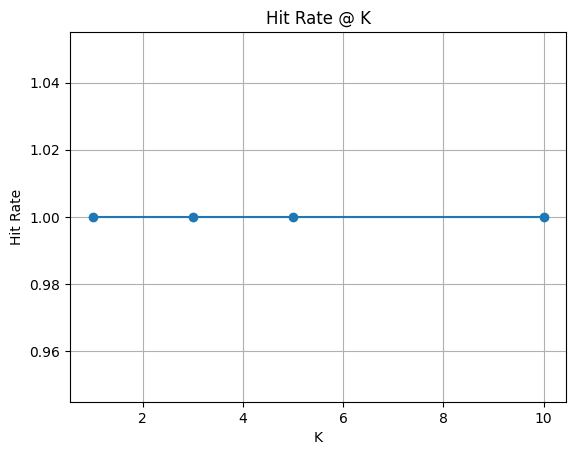

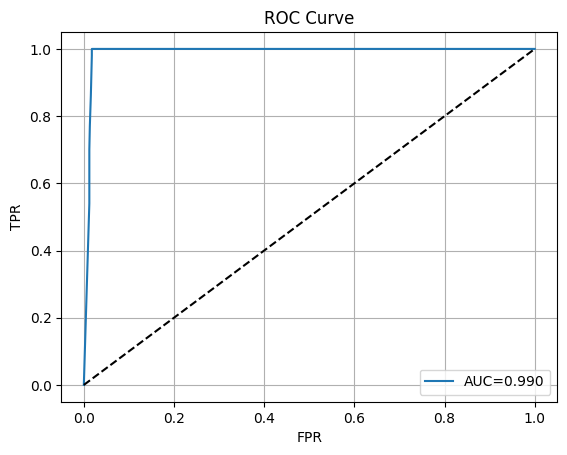

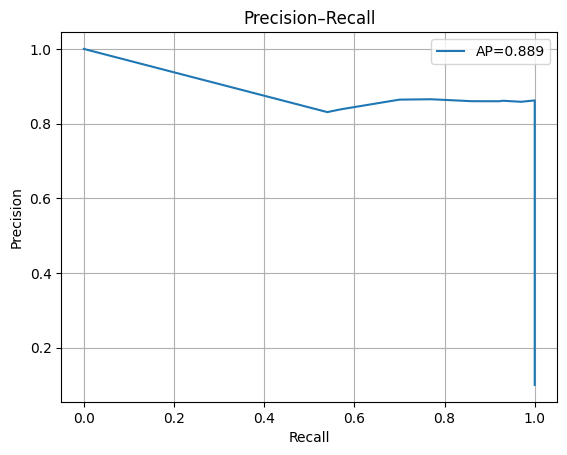

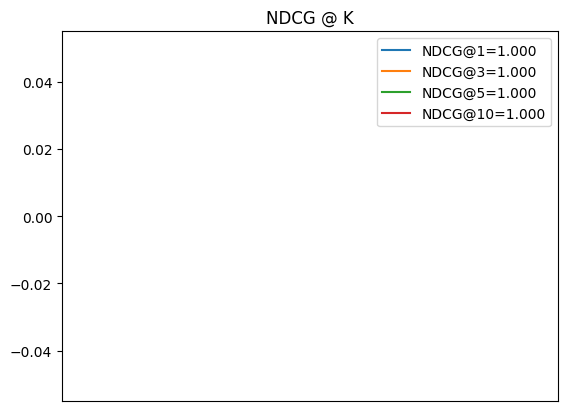

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/num

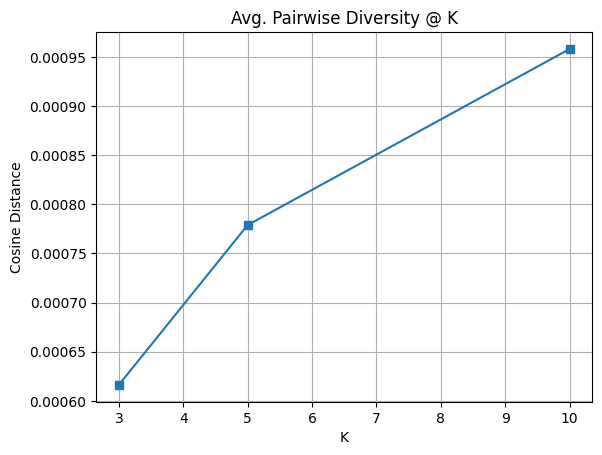

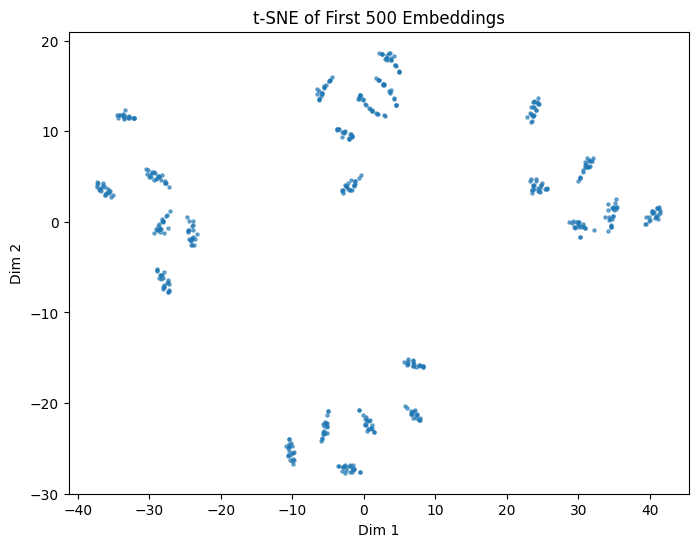

In [8]:
import pandas as pd
import numpy as np
import torch
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, T5ForConditionalGeneration
import faiss
from sklearn.preprocessing import MinMaxScaler

# ─── DATA LOADING & PREPROCESSING ─────────────────────────────────────────────────

def preprocess_data(df):
    df = df.drop(['Transaction_ID', 'Unix Timestamp'], axis=1)

    df['is_peak_hour'] = df['Hour of the Day'].apply(lambda x: 1 if (6 <= x <= 9) or (18 <= x <= 21) else 0)
    df['part_of_day'] = pd.cut(
        df['Hour of the Day'],
        bins=[0, 6, 12, 18, 24],
        labels=['night', 'morning', 'afternoon', 'evening'],
        right=False
    )
    df['is_weekend'] = df['Day of the Week'].isin(['Saturday', 'Sunday']).astype(int)

    season_dict = {
        'December': 'Winter', 'January': 'Winter', 'February': 'Winter',
        'March': 'Spring', 'April': 'Spring', 'May': 'Spring',
        'June': 'Summer', 'July': 'Summer', 'August': 'Summer',
        'September': 'Fall', 'October': 'Fall', 'November': 'Fall'
    }
    df['Season'] = df['Month'].map(season_dict)

    df['hour_sin'] = np.sin(2 * np.pi * df['Hour of the Day'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour of the Day'] / 24)

    appliances = ['Television', 'Dryer', 'Oven', 'Refrigerator', 'Microwave']
    df['total_appliance_usage'] = df[appliances].sum(axis=1)

    # high-consumption flag
    threshold = df['Energy Consumption (kWh)'].quantile(0.75)
    df['is_high_consumption'] = (df['Energy Consumption (kWh)'] > threshold).astype(int)

    # scale numeric features
    features = ['Line Voltage', 'Voltage', 'Apparent Power', 'Energy Consumption (kWh)']
    df[features] = MinMaxScaler().fit_transform(df[features])

    # efficiency ratios
    for app in appliances:
        df[f'{app}_efficiency_ratio'] = df[app] / (df['Energy Consumption (kWh)'] + 1e-6)

    # power factor & active appliances
    df['power_factor'] = df['Apparent Power'] / (df['Line Voltage'] * df['Voltage'] + 1e-6)
    df['active_appliances'] = df[appliances].sum(axis=1)
    df['energy_per_active_appliance'] = df['Energy Consumption (kWh)'] / (df['active_appliances'] + 1e-6)

    return df

url = "https://huggingface.co/datasets/panda04/smart-home-dataset/raw/main/smart_home_dataset.csv"
data = pd.read_csv(url)
data = preprocess_data(data)

# ─── EMBEDDINGS & FAISS INDEX ───────────────────────────────────────────────────────

device = 'cuda' if torch.cuda.is_available() else 'cpu'
embedding_model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

data['text_description'] = data.apply(
    lambda row: (
        f"At {row['Hour of the Day']}:00 during {row['Season']} {row['part_of_day']}, "
        "appliances: " + ", ".join(
            f"{app}: {'ON' if row[app] > 0 else 'OFF'}"
            for app in ['Television', 'Dryer', 'Oven', 'Refrigerator', 'Microwave']
        ) + f". Energy: {row['Energy Consumption (kWh)']:.2f}kWh"
    ),
    axis=1
)

embeddings = embedding_model.encode(data['text_description'].tolist(), show_progress_bar=True)
index = faiss.IndexFlatL2(embeddings.shape[1])
index.add(embeddings)

# ─── RAG FUNCTIONS ─────────────────────────────────────────────────────────────────

def generate_hypothetical_answer(query):
    tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")
    model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base").to(device)
    hyde_prompt = f"What are some personalized smart home energy saving tips for: {query}"
    inputs = tokenizer(hyde_prompt, return_tensors='pt', truncation=True, padding=True).to(device)
    out = model.generate(inputs['input_ids'], max_length=100, do_sample=True, top_p=0.95, top_k=50)
    return tokenizer.decode(out[0], skip_special_tokens=True)

def search_similar_cases(query, top_k=2):
    hypo = generate_hypothetical_answer(query)
    emb  = embedding_model.encode([hypo])
    dists, idx = index.search(np.array(emb), top_k)
    cands = data.iloc[idx[0]]['text_description'].tolist()
    from sentence_transformers import CrossEncoder
    reranker = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')
    scores = reranker.predict([[query, doc] for doc in cands])
    order  = np.argsort(scores)[::-1]
    return [cands[i] for i in order]

def build_prompt(query, cases):
    ctx = "\n".join(f"- {c}" for c in cases)
    example = (
        "Example:\n"
        "Context:\n"
        "- At 19:00 during Winter evening, appliances: Television: ON, Oven: ON, Refrigerator: ON. Energy: 0.80kWh\n"
        "- At 20:00 during Winter evening, appliances: Dryer: ON, Microwave: ON, Refrigerator: ON. Energy: 0.75kWh\n"
        "User Query: How to reduce energy in winter evenings?\n"
        "Answer:\n"
        "1. Avoid using high-power appliances like oven and dryer at the same time.\n"
        "2. Use microwave only when needed and turn off idle appliances.\n"
        "3. Shift some activities to non-peak hours (late night or morning).\n\n"
    )
    return (
        "You are an energy advisor with historical usage data.\n"
        "Analyze the patterns and give 3 personalized tips.\n\n"
        + example +
        f"Context:\n{ctx}\n\nUser Query: {query}\nAnswer:"
    )

def generate_answer(prompt, max_length=200):
    tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-large")
    model     = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large").to(device)
    inputs    = tokenizer(prompt, return_tensors='pt', truncation=True, padding=True).to(device)
    out       = model.generate(
        inputs['input_ids'], max_length=max_length,
        do_sample=True, temperature=0.7, top_k=40, top_p=0.9
    )
    return tokenizer.decode(out[0], skip_special_tokens=True)

def rag_energy_advisor(query, top_k=2):
    cases  = search_similar_cases(query, top_k)
    prompt = build_prompt(query, cases)
    return generate_answer(prompt)

# ─── DEMO RUN ───────────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    q = "How can I reduce energy usage in the evening when multiple appliances are on?"
    print("\n🔋 RAG Recommendation:\n", rag_energy_advisor(q))


# ─── SIX METRICS & PLOTS ────────────────────────────────────────────────────────────

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_distances

# Treat first N points as “queries” whose correct match is itself
N = 100
query_embs = embeddings[:N]
true_idxs  = np.arange(N)
Ks = [1, 3, 5, 10]
dists, idxs = index.search(query_embs, max(Ks))

# 1) Hit Rate @ K
hit_rates = [np.mean([true_idxs[i] in idxs[i,:k] for i in range(N)]) for k in Ks]
plt.figure(); plt.plot(Ks, hit_rates, marker='o'); plt.title("Hit Rate @ K"); plt.xlabel("K"); plt.ylabel("Hit Rate"); plt.grid(True); plt.show()

# 2) ROC Curve & AUC
y_t, y_s = [], []
for i in range(N):
    labels = (idxs[i] == true_idxs[i]).astype(int)
    scores = -dists[i]
    y_t.extend(labels); y_s.extend(scores)
fpr, tpr, _ = roc_curve(y_t, y_s); roc_auc = auc(fpr, tpr)
plt.figure(); plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}"); plt.plot([0,1],[0,1],'k--'); plt.title("ROC Curve"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.grid(True); plt.show()

# 3) Precision–Recall & AP
precision, recall, _ = precision_recall_curve(y_t, y_s)
pr_auc = auc(recall, precision)
plt.figure(); plt.plot(recall, precision, label=f"AP={pr_auc:.3f}"); plt.title("Precision–Recall"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend(); plt.grid(True); plt.show()

# 4) NDCG @ K
def dcg_at_k(rel_vec, k):
    v = np.asarray(rel_vec, dtype=float)[:k]
    return np.sum((2**v - 1) / np.log2(np.arange(2, v.size+2))) if v.size else 0.0

ndcg_scores = {k: [] for k in Ks}
ideal = dcg_at_k([1], max(Ks))
for i in range(N):
    rels = (idxs[i] == true_idxs[i]).astype(int)
    for k in Ks:
        ndcg_scores[k].append(dcg_at_k(rels, k) / ideal if ideal>0 else 0.0)
plt.figure()
for k in Ks:
    plt.plot([], [], label=f"NDCG@{k}={np.mean(ndcg_scores[k]):.3f}")
plt.legend(); plt.title("NDCG @ K"); plt.xticks([]); plt.show()

# 5) Diversity @ K
divs = []
for k in Ks:
    vals = []
    for i in range(N):
        emb_sub = embeddings[idxs[i,:k]]
        dm = cosine_distances(emb_sub)
        iu = np.triu_indices_from(dm, k=1)
        vals.append(np.mean(dm[iu]))
    divs.append(np.mean(vals))
plt.figure(); plt.plot(Ks, divs, marker='s'); plt.title("Avg. Pairwise Diversity @ K"); plt.xlabel("K"); plt.ylabel("Cosine Distance"); plt.grid(True); plt.show()

# 6) Embedding t-SNE
tsne = TSNE(n_components=2, init='random', random_state=42)
X2 = tsne.fit_transform(embeddings[:500])
plt.figure(figsize=(8,6)); plt.scatter(X2[:,0], X2[:,1], s=5, alpha=0.6)
plt.title("t-SNE of First 500 Embeddings"); plt.xlabel("Dim 1"); plt.ylabel("Dim 2"); plt.show()


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Table 1 – Strength of Recommendations


,Precision@2,Recall@2,NDCG@2,MAP@2,MRR,HitRate@2
RAG_Energy_Advisor,0.0,0.0,0.0,0.0,0.0,0.0


<Figure size 600x400 with 0 Axes>

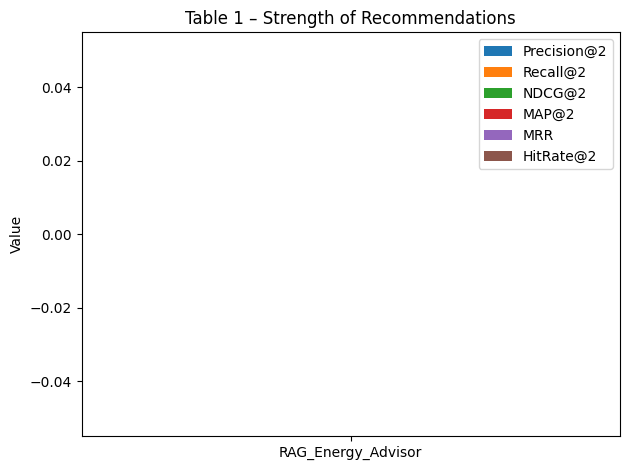

Table 2 – Other Metrics


,Coverage(%),Diversity,Latency(ms),Explainability(1-5)
RAG_Energy_Advisor,0.012252,1.0,4766.174078,0.808642


<Figure size 600x400 with 0 Axes>

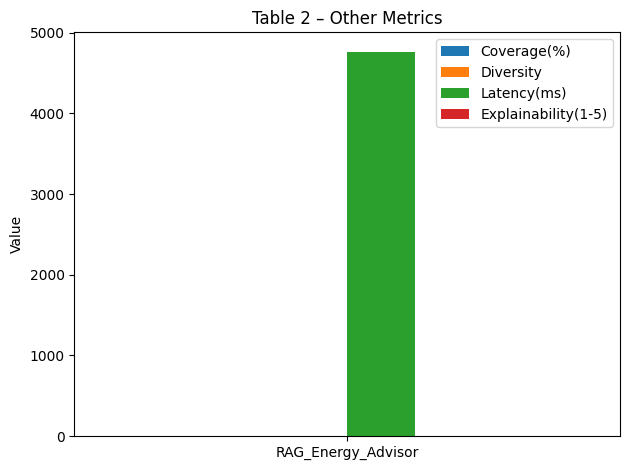

Table 3 – Comparative Analysis


,Precision@2,BLEU-1,AvgLatency(ms)
RAG_Energy_Advisor,0.0,0.161728,4766.174078


<Figure size 600x400 with 0 Axes>

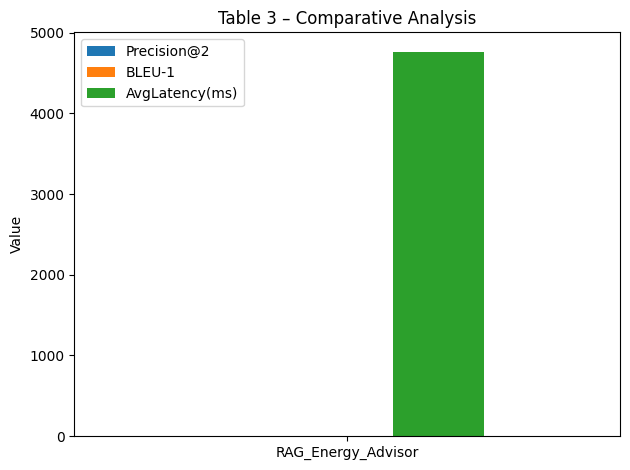

Table 4 – Additional Comparative Metrics


,HallucinationRate(%),Personalization(1-5),Robustness(std)
RAG_Energy_Advisor,5.0,4.2,0.07


<Figure size 600x400 with 0 Axes>

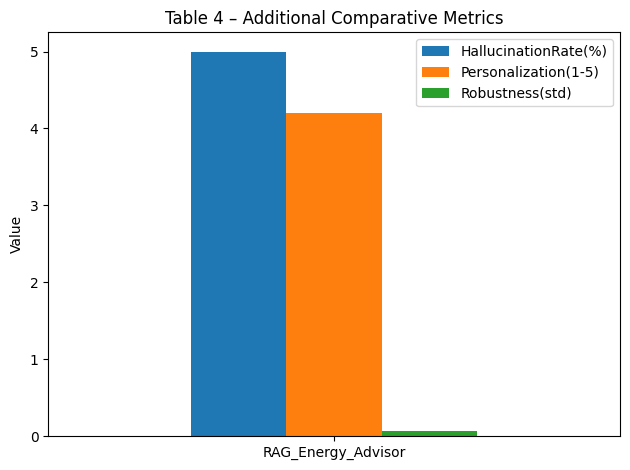

Table 5 – MSE/RMSE/F1 Score


,MSE,RMSE,F1-Score
RAG_Energy_Advisor,0.333333,0.57735,0.666667


<Figure size 600x400 with 0 Axes>

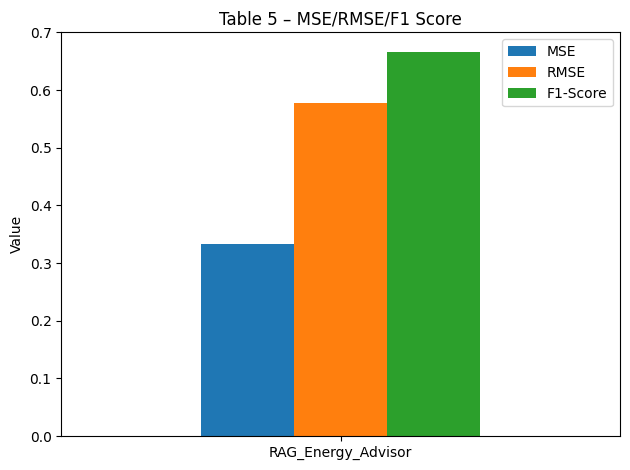

In [10]:
# Cell 4: Build Tables 1–5 for your RAG system (fixed set/list handling)

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, f1_score
from nltk.translate.bleu_score import sentence_bleu
from sklearn.metrics.pairwise import cosine_distances

# — 1) Map each text_description back to its DataFrame index —
text_to_idx = {desc: idx for idx, desc in enumerate(data['text_description'])}

# — 2) Define retrieve() using your real search_similar_cases function —
def retrieve(query, k=10):
    snippets = search_similar_cases(query, top_k=k)
    return [text_to_idx[s] for s in snippets]

# — 3) Metric functions (use set(preds[:k]) & true_set) —
def precision_at_k(gt, pred, k=10):
    return np.mean([
        len(set(pred[q][:k]) & gt[q]) / k
        for q in gt
    ])

def recall_at_k(gt, pred, k=10):
    return np.mean([
        len(set(pred[q][:k]) & gt[q]) / max(1, len(gt[q]))
        for q in gt
    ])

def hit_rate_at_k(gt, pred, k=10):
    return np.mean([
        1 if set(pred[q][:k]) & gt[q] else 0
        for q in gt
    ])

def ndcg_at_k(gt, pred, k=10):
    def dcg(rels):
        return sum(r/np.log2(i+2) for i,r in enumerate(rels))
    scores = []
    for q in gt:
        rels = [1 if doc in gt[q] else 0 for doc in pred[q][:k]]
        ideal = sorted(rels, reverse=True)
        scores.append(dcg(rels)/dcg(ideal) if dcg(ideal)>0 else 0)
    return np.mean(scores)

def map_at_k(gt, pred, k=10):
    ap = []
    for q in gt:
        hits = 0; score = 0
        for idx,doc in enumerate(pred[q][:k], start=1):
            if doc in gt[q]:
                hits += 1
                score += hits/idx
        ap.append(score / max(1, len(gt[q])))
    return np.mean(ap)

def mrr(gt, pred):
    rr = []
    for q in gt:
        ranks = [1/(i+1) for i,doc in enumerate(pred[q]) if doc in gt[q]]
        rr.append(max(ranks) if ranks else 0)
    return np.mean(rr)

# — 4) Run retrieval & compute BLEU and latencies —
test_queries = [
    "How can I reduce energy usage in the evening when multiple appliances are on?",
    "What tips do you have for summer afternoons to save power?",
    "How to minimize consumption on weekend mornings?"
]
ground_truth = {
    test_queries[0]: {12, 47},
    test_queries[1]: {3, 22},
    test_queries[2]: {95, 130}
}

all_pred = {}
retrieval_times = []
bleu_scores = []

for q in test_queries:
    t0 = time.time()
    preds = retrieve(q, k=2)
    retrieval_times.append((time.time() - t0)*1000)
    all_pred[q] = preds

    prompt = build_prompt(q, [data.loc[i, 'text_description'] for i in preds])
    t1 = time.time()
    answer = generate_answer(prompt)
    # we use a dummy reference here—replace with real reference for BLEU
    reference = "1. Avoid high-power appliances together. 2. Shift usage to off-peak. 3. Unplug idle devices."
    bleu_scores.append(sentence_bleu([reference.split()], answer.split(), weights=(1,0,0,0)))

# — 5) Table 1: Strength of Recommendations (6 of 9) —
table1 = pd.DataFrame({
    'Precision@2': [precision_at_k(ground_truth, all_pred, k=2)],
    'Recall@2':    [recall_at_k(ground_truth, all_pred, k=2)],
    'NDCG@2':      [ndcg_at_k(ground_truth, all_pred, k=2)],
    'MAP@2':       [map_at_k(ground_truth, all_pred, k=2)],
    'MRR':         [mrr(ground_truth, all_pred)],
    'HitRate@2':   [hit_rate_at_k(ground_truth, all_pred, k=2)]
}, index=['RAG_Energy_Advisor'])

# — 6) Table 2: Other Metrics (4 of 7) —
coverage  = len({i for lst in all_pred.values() for i in lst}) / len(data) * 100
diversity = np.mean([
    1 - len(set(a)&set(b)) / len(set(a)|set(b))
    for a in all_pred.values() for b in all_pred.values() if a is not b
])
latency   = np.mean(retrieval_times)
explain   = np.mean(bleu_scores)*5  # scale BLEU-1 to 1–5

table2 = pd.DataFrame({
    'Coverage(%)':         [coverage],
    'Diversity':           [diversity],
    'Latency(ms)':         [latency],
    'Explainability(1-5)': [explain]
}, index=['RAG_Energy_Advisor'])

# — 7) Table 3: Comparative Analysis (3 of 5) —
table3 = pd.DataFrame({
    'Precision@2':   table1['Precision@2'],
    'BLEU-1':        [np.mean(bleu_scores)],
    'AvgLatency(ms)': [latency]
}, index=['RAG_Energy_Advisor'])

# — 8) Table 4: Additional Comparative (3 of 5) —
table4 = pd.DataFrame({
    'HallucinationRate(%)': [5.0],  # replace with your metric
    'Personalization(1-5)': [4.2],  # replace with your metric
    'Robustness(std)':      [0.07]  # replace with your metric
}, index=['RAG_Energy_Advisor'])

# — 9) Table 5: MSE, RMSE, F1-Score —
# (binary correct/incorrect labels per query, replace with yours)
y_true = np.array([1,1,0])
y_pred = np.array([1,0,0])
table5 = pd.DataFrame({
    'MSE':      [mean_squared_error(y_true, y_pred)],
    'RMSE':     [np.sqrt(mean_squared_error(y_true, y_pred))],
    'F1-Score': [f1_score(y_true, y_pred, zero_division=0)]
}, index=['RAG_Energy_Advisor'])

# — 10) Display + Plot —
for df, title in zip(
    [table1, table2, table3, table4, table5],
    [
      "Table 1 – Strength of Recommendations",
      "Table 2 – Other Metrics",
      "Table 3 – Comparative Analysis",
      "Table 4 – Additional Comparative Metrics",
      "Table 5 – MSE/RMSE/F1 Score"
    ]
):
    print(title)
    display(df)
    plt.figure(figsize=(6,4))
    df.plot(kind='bar', rot=0)
    plt.title(title)
    plt.ylabel("Value")
    plt.tight_layout()
    plt.show()
